In [4]:
import osqp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy import sparse

### fempos test

Three quadratic penalties are involved:
1. Penalty x on distance between middle point and point by finite element estimate;
2. Penalty y on path length;
3. Penalty z on difference between points and reference points

cost1 : $$\sum ((p_1 + p_3) - 2*p_2)^2$$
cost2 : $$\sum ((p_{n+1} - p_n)^2)$$
cost3 : $$\sum ((p_n - p_{refn})^2$$

General formulation of P matrix is as below(with 6 points as an example):
I is a two by two identity matrix, X, Y, Z represents x * I, y * I, z * I
0 is a two by two zero matrix

$$\begin{vmatrix}
X+Y+Z&-2X-Y&X&0&0&0\\
0&5X+2Y+Z&-4X-Y&X&0&0\\
0&0&6X+2Y+Z&-4X-Y&X&0\\
0&0&0&6X+2Y+4Z&-4X-Y&X\\
0&0&0&0&5X+2Y+Z&-2X-Y\\
0&0&0&0&0&X+Y+Z\\
\end{vmatrix}$$

 Only upper triangle needs to be filled

#### 计算s和kappa

In [5]:
def calcKappa(x_array,y_array):
    s_array = []
    k_array = []
    if(len(x_array) != len(y_array)):
        return(s_array , k_array)
    
    length = len(x_array)
    temp_s = 0.0
    s_array.append(temp_s)
    for i in range(1 , length):
        temp_s += np.sqrt(np.square(y_array[i] - y_array[i - 1]) + np.square(x_array[i] - x_array[i - 1]))
        s_array.append(temp_s)

    xds,yds,xdds,ydds = [],[],[],[]
    for i in range(length):
        if i == 0:
            xds.append((x_array[i + 1] - x_array[i]) / (s_array[i + 1] - s_array[i]))
            yds.append((y_array[i + 1] - y_array[i]) / (s_array[i + 1] - s_array[i]))
        elif i == length - 1:
            xds.append((x_array[i] - x_array[i-1]) / (s_array[i] - s_array[i-1]))
            yds.append((y_array[i] - y_array[i-1]) / (s_array[i] - s_array[i-1]))
        else:
            xds.append((x_array[i+1] - x_array[i-1]) / (s_array[i+1] - s_array[i-1]))
            yds.append((y_array[i+1] - y_array[i-1]) / (s_array[i+1] - s_array[i-1]))
    for i in range(length):
        if i == 0:
            xdds.append((xds[i + 1] - xds[i]) / (s_array[i + 1] - s_array[i]))
            ydds.append((yds[i + 1] - yds[i]) / (s_array[i + 1] - s_array[i]))
        elif i == length - 1:
            xdds.append((xds[i] - xds[i-1]) / (s_array[i] - s_array[i-1]))
            ydds.append((yds[i] - yds[i-1]) / (s_array[i] - s_array[i-1]))
        else:
            xdds.append((xds[i+1] - xds[i-1]) / (s_array[i+1] - s_array[i-1]))
            ydds.append((yds[i+1] - yds[i-1]) / (s_array[i+1] - s_array[i-1]))
    for i in range(length):
        k_array.append((xds[i] * ydds[i] - yds[i] * xdds[i]) / (np.sqrt(xds[i] * xds[i] + yds[i] * yds[i]) * (xds[i] * xds[i] + yds[i] * yds[i]) + 1e-6));
    return(s_array,k_array)


#### fem_pos_smoother(至少需要6个点)

In [6]:
def FemPosSmooth(x_array,y_array):
    opt_x = []
    opt_y = []
    if(len(x_array) != len(y_array)):
        return(opt_x , opt_y)
    length = len(x_array)

    weight_fem_pos_deviation_ = 1e7 #cost1 - x
    weight_path_length = 1          #cost2 - y
    weight_ref_deviation = 1        #cost3 - z

    P = np.zeros((length,length))
    q = np.zeros(length)
    #add cost1
    P[0,0] = 1 * weight_fem_pos_deviation_
    P[0,1] = -2 * weight_fem_pos_deviation_
    P[1,1] = 5 * weight_fem_pos_deviation_
    P[length - 1 , length - 1] = 1 * weight_fem_pos_deviation_
    P[length - 2 , length - 1] = -2 * weight_fem_pos_deviation_
    P[length - 2 , length - 2] = 5 * weight_fem_pos_deviation_

    for i in range(2 , length - 2):
        P[i , i] = 6 * weight_fem_pos_deviation_
    for i in range(2 , length - 1):
        P[i - 1, i] = -4 * weight_fem_pos_deviation_
    for i in range(2 , length):
        P[i - 2, i] = 1 * weight_fem_pos_deviation_

    P = P / weight_fem_pos_deviation_
    

    P = sparse.csc_matrix(P)

    #add constraints for x 
    bound = 0.15
    A = np.zeros((length,length))
    for i in range(length):
        A[i, i] = 1
    A = sparse.csc_matrix(A)
    lx = np.array(x_array) - bound
    ux = np.array(x_array) + bound
    ly = np.array(y_array) - bound
    uy = np.array(y_array) + bound
    
    lx[0] = x_array[0]
    ux[0] = x_array[0]
    ly[0] = y_array[0]
    uy[0] = y_array[0]



    #solve
    prob = osqp.OSQP()
    prob.setup(P,q,A,lx,ux)
    res = prob.solve()
    opt_x = res.x

    prob.update(l=ly, u=uy)
    res = prob.solve()
    opt_y = res.x
    return(opt_x , opt_y)


In [ ]:
def FemPosSmooth(x_array,y_array):
    opt_x = []
    opt_y = []
    if(len(x_array) != len(y_array)):
        return(opt_x , opt_y)
    length = len(x_array)

    weight_fem_pos_deviation_ = 1e7 #cost1 - x
    weight_path_length = 1          #cost2 - y
    weight_ref_deviation = 1        #cost3 - z

    P = np.zeros((length,length))
    q = np.zeros(length)
    #add cost1
    P[0,0] = 1 * weight_fem_pos_deviation_
    P[0,1] = -2 * weight_fem_pos_deviation_
    P[1,1] = 5 * weight_fem_pos_deviation_
    P[length - 1 , length - 1] = 1 * weight_fem_pos_deviation_
    P[length - 2 , length - 1] = -2 * weight_fem_pos_deviation_
    P[length - 2 , length - 2] = 5 * weight_fem_pos_deviation_

    for i in range(2 , length - 2):
        P[i , i] = 6 * weight_fem_pos_deviation_
    for i in range(2 , length - 1):
        P[i - 1, i] = -4 * weight_fem_pos_deviation_
    for i in range(2 , length):
        P[i - 2, i] = 1 * weight_fem_pos_deviation_

    P = P / weight_fem_pos_deviation_
    

    P = sparse.csc_matrix(P)

    #add constraints for x 
    bound = 0.15
    A = np.zeros((length,length))
    for i in range(length):
        A[i, i] = 1
    A = sparse.csc_matrix(A)
    lx = np.array(x_array) - bound
    ux = np.array(x_array) + bound
    ly = np.array(y_array) - bound
    uy = np.array(y_array) + bound
    
    lx[0] = x_array[0]
    ux[0] = x_array[0]
    ly[0] = y_array[0]
    uy[0] = y_array[0]



    #solve
    prob = osqp.OSQP()
    prob.setup(P,q,A,lx,ux)
    res = prob.solve()
    opt_x = res.x

    prob.update(l=ly, u=uy)
    res = prob.solve()
    opt_y = res.x
    return(opt_x , opt_y)


#### fem pos sample 
优化输入的10个点，绘制平滑前后的x-y ，bound,s-kappa

In [7]:
#add some data for test
x_array = [0.5,1.0,2.0,3.0,4.0,
           5.0,6.0,7.0,8.0,9.0]
y_array = [0.1,0.3,0.2,0.4,0.3,
           -0.2,-0.1,0,0.5,0]

length = len(x_array)

weight_fem_pos_deviation_ = 1e7 #cost1 - x
weight_path_length = 1          #cost2 - y
weight_ref_deviation = 1        #cost3 - z


P = np.zeros((length,length))
q = np.zeros(length)
#add cost1
P[0,0] = 1 * weight_fem_pos_deviation_
P[0,1] = -2 * weight_fem_pos_deviation_
P[1,1] = 5 * weight_fem_pos_deviation_
P[length - 1 , length - 1] = 1 * weight_fem_pos_deviation_
P[length - 2 , length - 1] = -2 * weight_fem_pos_deviation_
P[length - 2 , length - 2] = 5 * weight_fem_pos_deviation_

for i in range(2 , length - 2):
    P[i , i] = 6 * weight_fem_pos_deviation_
for i in range(2 , length - 1):
    P[i - 1, i] = -4 * weight_fem_pos_deviation_
for i in range(2 , length):
    P[i - 2, i] = 1 * weight_fem_pos_deviation_

P = sparse.csc_matrix(P)

#add constraints for x 
bound = 0.15
A = np.zeros((length,length))
for i in range(length):
    A[i, i] = 1
A = sparse.csc_matrix(A)
lx = np.array(x_array) - bound
ux = np.array(x_array) + bound
ly = np.array(y_array) - bound
uy = np.array(y_array) + bound


#solve
prob = osqp.OSQP()
prob.setup(P,q,A,lx,ux)
res = prob.solve()
opt_x = res.x

prob.update(l=ly, u=uy)
res = prob.solve()
opt_y = res.x

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 10, constraints m = 10
          nnz(P) + nnz(A) = 37
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   8.85e+00   4.03e+07   1.00e-01   7.31e-05s
  50   4.4665e+04   3.95e-04   9.08e+00   1.39e-02   1.70e-04s

status:               solved
number of iteratio

In [8]:
#plot x - y , opt_x - opt_y , lb - ub

fig1 = plt.figure(dpi = 100 , figsize=(12, 8))
ax1_1 = fig1.add_subplot(2,1,1)

ax1_1.plot(x_array,y_array , ".--", color = "grey", label="orig x-y")
ax1_1.plot(opt_x, opt_y,".-",label = "opt x-y")
ax1_1.plot(x_array,ly,".--r",label = "bound")
ax1_1.plot(x_array,uy,".--r")
ax1_1.legend()
ax1_1.grid(axis="y",ls='--')

#plot kappa
ax1_2 = fig1.add_subplot(2,1,2)
s_orig,k_orig = calcKappa(x_array,y_array)
s_opt ,k_opt = calcKappa(opt_x,opt_y)
ax1_2.plot(s_orig , k_orig , ".--", color = "grey", label="orig s-kappa")
ax1_2.plot(s_opt,k_opt,".-",label="opt s-kappa")
ax1_2.legend()
ax1_2.grid(axis="y",ls='--')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 处理本地数据
读取本地数据，测试下不同曲率下使用fem_pos_smoother的平滑效果

In [7]:
xy_arr = np.loadtxt('./xy.txt' , usecols=(0, 1))
start = 400
end = 500
xy_sec = xy_arr[start:end , :]
opt_x,opt_y = FemPosSmooth(xy_sec[:,0],xy_sec[:,1])
opt_s,opt_k = calcKappa(opt_x,opt_y)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 100, constraints m = 100
          nnz(P) + nnz(A) = 397
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+03   2.96e+05   1.00e-01   1.14e-04s
  50   3.6053e-03   5.36e-03   1.47e-05   1.31e-03   2.91e-04s

status:               solved
number of itera

In [9]:
#plot origin data
fig2 = plt.figure(dpi = 100 , figsize=(12, 8))
ax2_1 = fig2.add_subplot(211)
ax2_1.plot(xy_sec[:,0],xy_sec[:,1],".-",color = "grey")
ax2_1.axis('equal')
ax2_2 = fig2.add_subplot(212)
s_arr,k_arr = calcKappa(xy_sec[:,0],xy_sec[:,1])
ax2_2.plot(s_arr,k_arr,".-",color = "grey")

#plot opt data
ax2_1.plot(opt_x,opt_y,".-")
ax2_2.plot(opt_s,opt_k,".-")
ax2_2.grid()


from ipywidgets import interact, widgets, Layout

step = 200 #曲线长度
length = len(xy_arr[:,0])
time_slider = widgets.FloatSlider(
    discription = "per [%]",
    value=0,
    min=0,
    max=100,
    step=0.1,
    layout=Layout(width='100%', height='80px', top='1px')
)
@interact(t_input=time_slider)
def target_trajectory(t_input):
    idx_t = int(t_input / 100 * length)
    start = idx_t
    end = min(idx_t + step , length - 1)
    xy_sec = xy_arr[start:end , :]
    s_arr,k_arr = calcKappa(xy_sec[:,0],xy_sec[:,1])
    opt_x,opt_y = FemPosSmooth(xy_sec[:,0],xy_sec[:,1])
    opt_s,opt_k = calcKappa(opt_x,opt_y)
    
    ax2_1.cla()
    ax2_1.plot(xy_sec[:,0],xy_sec[:,1],".-",color = "grey",label="orig x-y")
    ax2_1.plot(opt_x,opt_y,".-",label="opg x-y")
    ax2_1.axis('equal')
    ax2_1.legend()
    
    ax2_2.cla()
    ax2_2.plot(s_arr,k_arr,".-",color = "grey",label="orig s-kappa")
    ax2_2.plot(opt_s,opt_k,".-",label="opt s-kappa")
    ax2_2.set_ylim(-0.5,0.5)
    ax2_2.legend()
    ax2_2.grid()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='t_input', layout=Layout(height='80px', top='1px', wi…

### piecewise_jerk_path
将x，x' , x''都扔在一个矩阵里求解

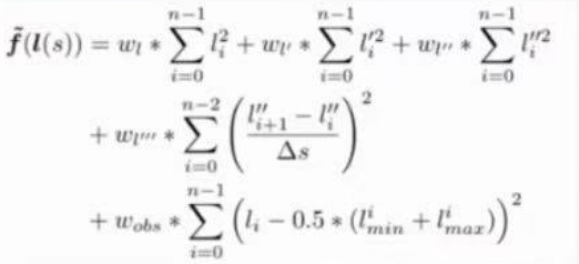

In [ ]:
#set start / end
start_l = 0.0
start_dl = 0.0
start_ddl = 0.0
end_l = 10.0
end_dl = 0.0
end_ddl = 0.0
val = 0.5
n = int((end_l - start_l)/val)
bound = 3.0
delta_s_square = val * val

weight_x = 1
weight_x_ref = 0  #这里代码中是个vector（GaussianWeighting）表示的，需要再看一下
weight_dx = 2544.58
weight_ddx = 1000
weight_dddx = 50000
weight_end_x = 1000
weight_end_dx = 0
weight_end_ddx = 0
scale_factor_1 = 1
scale_factor_2 = 10
scale_factor_3 = 100

#代码中还有一个scale_factor_{1.0，10.0，100.0}，再看一下

P = np.zeros((3*n,3*n))
q = np.zeros(3*n)

#calculate kernel
for i in range(0, n-1):
    P[i , i] = weight_x + weight_x_ref
P[n-1, n-1] = weight_x + weight_x_ref + weight_end_x

for i in range(n, 2*n-1):
    P[i , i] = weight_dx
P[2*n-1, 2*n-1] = weight_dx + weight_end_dx


P[2*n, 2*n] = weight_ddx+ weight_dddx/delta_s_square
for i in range(2*n+1, 3*n-1):
    P[i , i] = weight_ddx + 2*weight_dddx / delta_s_square
P[3*n-1, 3*n-1] = (weight_ddx + weight_dddx / delta_s_square + weight_end_ddx)

for i in range(0, n-1):
    P[2*n+i+1, 2*n+i] = (-2.0 * weight_dddx / delta_s_square) 

#calculate offset
for i in range(0, n):
    q[i] = -2.0 * weight_x_ref #*x_ref[i]
q[n-1] = -2.0 * weight_end_x
q[2*n-1] = -2.0 * weight_end_dx
q[3*n-1] = -2.0 * weight_end_ddx

#calculate affine_constraint
A = np.zeros((3*n,3*n))
for i in range(3*n):
    A[i, i] = 1

lb = np.zeros(3*n) - bound
ub = np.zeros(3*n) + bound

lb.resize(4*n-1)
ub.resize(4*n-1)
A.resize((4*n-1,3*n))
for i in range(0 , n - 1):
    A[3*n+i,2*n+i] = -1.0
    A[3*n+i,2*n+i+1] = 1.0
    lb[3*n+i] = -bound*val
    ub[3*n+i] = bound*val
    
lb.resize(5*n-2)
ub.resize(5*n-2)
A.resize((5*n-2,3*n))
for i in range(0 , n-1):
    A[4*n-1+i,n+i] = -1.0
    A[4*n-1+i,n+i+1] = 1.0
    A[4*n-1+i,2*n+i] = -0.5*val
    A[4*n-1+i,2*n+i+1] = -0.5*val
    lb[4*n-1+i] = 0.0
    ub[4*n-1+i] = 0.0
    
lb.resize(6*n-3)
ub.resize(6*n-3)
A.resize((6*n-3,3*n))
for i in range(0 , n-1):
    A[5*n-2+i,i] = -1.0
    A[5*n-2+i,i+1] = 1.0
    A[5*n-2+i,n+i] = -val
    A[5*n-2+i,2*n+i] = -delta_s_square / 3.0
    A[5*n-2+i,2*n+i+1] = -delta_s_square / 6.0
    lb[5*n-2+i] = 0.0
    ub[5*n-2+i] = 0.0

lb.resize(6*n)
ub.resize(6*n)
A.resize((6*n,3*n))

A[6*n-3,0] = 1.0
lb[6*n-3] = start_l
ub[6*n-3] = start_l

A[6*n-2,0] = 1.0
lb[6*n-2] = start_dl
ub[6*n-2] = start_dl

A[6*n-1,0] = 1.0
lb[6*n-1] = start_ddl
ub[6*n-1] = start_ddl


print(P)
# print(q)
# print(A)
# print(lb)
# print(ub)

P = 2*P
P = sparse.csc_matrix(P)
A = sparse.csc_matrix(A)

#solve
prob1 = osqp.OSQP()
#prob1.setup(P)
prob1.setup(P,q,A,lb,ub)
res = prob1.solve()
opt_xy = res.x
print(opt_xy)


In [ ]:
s = []
l = []
dl = []
ddl = []
for i in range(n):
    s.append(val * i)
    l.append(opt_xy[i])
    dl.append(opt_xy[n+i])
    ddl.append(opt_xy[2*n+i])
    
#plot origin data
fig3 = plt.figure(dpi = 100 , figsize=(12, 8))
ax3_1 = fig3.add_subplot(311)
ax3_1.plot(s,l,".-",label="s-l")
ax3_1.legend()
ax3_2 = fig3.add_subplot(312)
ax3_2.plot(s,dl,".-",label="s-dl")
ax3_2.legend()
ax3_3 = fig3.add_subplot(313)
ax3_3.plot(s,ddl,".-",label="s-ddl")
ax3_3.legend()

Reference:
二次规划的一般表现形式：
$$
minimize \frac{1}{2} \cdot x^T \cdot P \cdot x + q \cdot x 
\\
s.t. LB \leq A\cdot x \leq UB
$$

PiecewiseJerkPath的cost
$$
f(l(s)) = w_l\cdot \sum_{i=0}^{n-1} l_i^2 + w_{{l}'}\cdot \sum_{i=0}^{n-1} {l_i}'^2 + w_{{l}''}\cdot \sum_{i=0}^{n-1} {l_i}''^2 + w_{{l}'''}\cdot \sum_{i=0}^{n-2}(\frac{{l_{i+1}}'' - {l_i}''}{\Delta s})^2 \\
+w_{obs}\cdot \sum_{i=0}^{n-1}(l_i-l_{ref})^2 \\
+w_{end_l}\cdot (l_{n-1} - l_{endref})^2 + w_{end_{dl}}\cdot ({l}'_{n-1}-{l_{endref}}')^2 + w_{end_{ddl}}\cdot ({l}''_{n-1} - {l_{endref}}'')^2
$$

PiecewiseJerkPath的bound约束

$$
{l_{i+1}}'' = \int_{0}^{\Delta s}{l_{i->i+1}}'''ds={l_i}''+{l_{i->i+1}}'''\cdot\Delta s\\
{l_{i+1}}'={l_i}'+\int_{0}^{\Delta s}{l}''(s)ds={l_i}'+{l_i}''\cdot\Delta s+\frac{1}{2}{l_{i->i+1}}'''\cdot\Delta s^2\\
l_{i+1}=l_i+\int_{0}^{\Delta s}{l}'(s)ds\\=l_i+(l_i)'\cdot\Delta s+\frac{1}{2}{l_i}''\cdot s^2+\frac{1}{6}{l_{i->i+1}}'''\cdot\Delta s^3
$$

PieceWiseJerkPath的P矩阵：

$$\begin{vmatrix}
w_l&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&w_l&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&w_l&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&w_l&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&w_l&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&w_l&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&w_{{l}'}&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&w_{{l}''}+\frac{w_{{l}'''}}{\Delta s^2}&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&-2\frac{w_{{l}'''}}{\Delta s^2}&w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&-2\frac{w_{{l}'''}}{\Delta s^2}&w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&-2\frac{w_{{l}'''}}{\Delta s^2}&w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&-2\frac{w_{{l}'''}}{\Delta s^2}&w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&-2\frac{w_{{l}'''}}{\Delta s^2}&w_{{l}''}+\frac{w_{{l}'''}}{\Delta s^2}\\
\end{vmatrix}$$

P矩阵 ref
$$\begin{vmatrix}
w_{ref_1}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&w_{ref_2}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&w_{ref_3}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&w_{ref_4}&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&w_{ref_5}&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&w_{ref_6}&0&0&0&0&0&0&0&0&0&0&0&0\\
\end{vmatrix}$$

$$\begin{vmatrix}
-2w_{ref_1}\cdot l_{ref_1}\\
-2w_{ref_2}\cdot l_{ref_2}\\
-2w_{ref_3}\cdot l_{ref_3}\\
-2w_{ref_4}\cdot l_{ref_4}\\
-2w_{ref_5}\cdot l_{ref_5}\\
-2w_{ref_6}\cdot l_{ref_6}\\
\end{vmatrix}$$

P矩阵 end
$$\begin{vmatrix}
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&w_{end_l}&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&w_{end_{dl}}&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&w_{end_{ddl}}\\
\end{vmatrix}$$

$$\begin{vmatrix}
0\\
0\\
0\\
0\\
0\\
-2w_{end_l}\cdot end_l\\
0\\
0\\
0\\
0\\
0\\
-2w_{end_dl}\cdot end_dl\\
0\\
0\\
0\\
0\\
0\\
-2w_{end_ddl}\cdot end_ddl\\
\end{vmatrix}$$

PieceWiseJerkPath的P矩阵：

$$\begin{vmatrix}
\frac{w_l+w_{ref_1}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&\frac{w_l+w_{ref_2}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&\frac{w_l+w_{ref_3}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&\frac{w_l+w_{ref_4}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&\frac{w_l+w_{ref_5}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&\frac{w_l+w_{ref_6}+w_{end_l}}{scale\_factor_0^2}&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&\frac{w_{{l}'}}{scale\_factor_1^2}&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&\frac{w_{{l}'}}{scale\_factor_1^2}&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&\frac{w_{{l}'}}{scale\_factor_1^2}&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&\frac{w_{{l}'}}{scale\_factor_1^2}&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&\frac{w_{{l}'}}{scale\_factor_1^2}&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&\frac{w_{{l}'}+w_{end_{dl}}}{scale\_factor_1^2}&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&\frac{w_{{l}''}+\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&\frac{-2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&\frac{w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&\frac{-2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&\frac{w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&\frac{-2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&\frac{w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&\frac{-2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&\frac{w_{{l}''}+2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&\frac{-2\frac{w_{{l}'''}}{\Delta s^2}}{scale\_factor_2^2}&\frac{w_{{l}''}+\frac{w_{{l}'''}}{\Delta s^2}+w_end_{ddl}}{scale\_factor_2^2}\\
\end{vmatrix}$$



$$\begin{vmatrix}
-2w_{ref_1}\cdot l_{ref_1} / scale\_factor_0\\
-2w_{ref_2}\cdot l_{ref_2}/ scale\_factor_0\\
-2w_{ref_3}\cdot l_{ref_3}/ scale\_factor_0\\
-2w_{ref_4}\cdot l_{ref_4}/ scale\_factor_0\\
-2w_{ref_5}\cdot l_{ref_5}/ scale\_factor_0\\
-2w_{ref_6}\cdot l_{ref_6}-2w_{end_l}\cdot end_l/ scale\_factor_0\\
0\\
0\\
0\\
0\\
0\\
-2w_{end_{dl}}\cdot end_{dl}/ scale\_factor_1\\
0\\
0\\
0\\
0\\
0\\
-2w_{end_{ddl}}\cdot end_{ddl}/ scale\_factor_2\\
\end{vmatrix}$$

Bound：


\begin{split}\begin{array}
 & \begin{bmatrix}
lb_{s1} \\ 
lb_{s2} \\ 
lb_{s3} \\
lb_{s4} \\ 
lb_{s5} \\ 
lb_{s6} 
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
ub_{s1} \\ 
ub_{s2} \\ 
ub_{s3} \\
ub_{s4} \\ 
ub_{s5} \\ 
ub_{s6} 
 \end{bmatrix}
\end{array}\end{split}

Bound：


\begin{split}\begin{array}
 & \begin{bmatrix}
-2.0 \\ 
-2.0 \\ 
-2.0 \\
-2.0 \\ 
-2.0 \\ 
-2.0 
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
2.0 \\ 
2.0 \\ 
2.0 \\
2.0 \\ 
2.0 \\ 
2.0 
 \end{bmatrix}
\end{array}\end{split}

Bound ddl：


\begin{split}\begin{array}
 & \begin{bmatrix}
-lat\_acc\_bound - kappa_{s1} \\ 
-lat\_acc\_bound - kappa_{s2} \\ 
-lat\_acc\_bound - kappa_{s3} \\
-lat\_acc\_bound - kappa_{s4} \\ 
-lat\_acc\_bound - kappa_{s5} \\ 
-lat\_acc\_bound - kappa_{s6} 
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
lat\_acc\_bound - kappa_{s1} \\ 
lat\_acc\_bound - kappa_{s2} \\ 
lat\_acc\_bound - kappa_{s3} \\
lat\_acc\_bound - kappa_{s4} \\ 
lat\_acc\_bound - kappa_{s5} \\ 
lat\_acc\_bound - kappa_{s6} 
 \end{bmatrix}
\end{array}\end{split}

Bound init：


\begin{split}\begin{array}
 & \begin{bmatrix}
ego_l \\ 
ego_{dl} \\ 
ego_{ddl} \\
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
ego_l \\ 
ego_{dl} \\ 
ego_{ddl} \\
 \end{bmatrix}
\end{array}\end{split}

Bound init：


\begin{split}\begin{array}
 & \begin{bmatrix}
-jerk_1 * \Delta s \\ 
-jerk_2 * \Delta s \\ 
-jerk_3 * \Delta s \\
-jerk_4 * \Delta s \\ 
-jerk_5 * \Delta s \\
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
0&0&0&0&0&0&0&0&0&0&0&0&-1&1&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&-1&1&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&-1&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&-1&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&-1&1\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
jerk_1 * \Delta s \\ 
jerk_2 * \Delta s \\ 
jerk_3 * \Delta s \\
jerk_4 * \Delta s \\ 
jerk_5 * \Delta s \\
 \end{bmatrix}
\end{array}\end{split}

Bound ddl：


\begin{split}\begin{array}
 & \begin{bmatrix}
0 \\ 
0 \\ 
0 \\
0 \\ 
0 \\
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
0&0&0&0&0&0&-1&1&0&0&0&0&-0.5\cdot\Delta s&-0.5\cdot\Delta s&0&0&0&0\\
0&0&0&0&0&0&0&-1&1&0&0&0&0&-0.5\cdot\Delta s&-0.5\cdot\Delta s&0&0&0\\
0&0&0&0&0&0&0&0&-1&1&0&0&0&0&-0.5\cdot\Delta s&-0.5\cdot\Delta s&0&0\\
0&0&0&0&0&0&0&0&0&-1&1&0&0&0&0&-0.5\cdot\Delta s&-0.5\cdot\Delta s&0\\
0&0&0&0&0&0&0&0&0&0&-1&1&0&0&0&0&-0.5\cdot\Delta s&-0.5\cdot\Delta s\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
0 \\ 
0 \\ 
0 \\
0 \\ 
0 \\
 \end{bmatrix}
\end{array}\end{split}

Bound dl：


\begin{split}\begin{array}
 & \begin{bmatrix}
0 \\ 
0 \\ 
0 \\
0 \\ 
0 \\
\end{bmatrix} 
 \leq 
 \begin{bmatrix} 
-1&1&0&0&0&0&-\Delta s&0&0&0&0&0&-\frac{1}{3}\Delta s^2&-\frac{1}{6}\Delta s^2&0&0&0&0\\
0&-1&1&0&0&0&0&-\Delta s&0&0&0&0&0&-\frac{1}{3}\Delta s^2&-\frac{1}{6}\Delta s^2&0&0&0\\
0&0&-1&1&0&0&0&0&-\Delta s&0&0&0&0&0&-\frac{1}{3}\Delta s^2&-\frac{1}{6}\Delta s^2&0&0\\
0&0&0&-1&1&0&0&0&0&-\Delta s&0&0&0&0&0&-\frac{1}{3}\Delta s^2&-\frac{1}{6}\Delta s^2&0\\
0&0&0&0&-1&1&0&0&0&0&-\Delta s&0&0&0&0&0&-\frac{1}{3}\Delta s^2&-\frac{1}{6}\Delta s^2\\
 \end{bmatrix} 
 x 
 \leq  
 \begin{bmatrix}
0 \\ 
0 \\ 
0 \\
0 \\ 
0 \\
 \end{bmatrix}
\end{array}\end{split}